In [530]:
import torch
from torchvision.models.segmentation import LRASPP_MobileNet_V3_Large_Weights

torch.random.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [531]:
from collections import deque


class FixedSizeQueue:
    def __init__(self, max_length):
        self.queue = deque([0] * max_length, maxlen=max_length)

    def enqueue(self, item):
        self.queue.append(item)

    def get_average(self):
        return sum(self.queue) / len(self.queue)

    def get_last(self):
        return self.queue[-1]

    def __str__(self):
        return str(list(self.queue))

In [532]:
class Creature:
    def __init__(self, tps):
        self.ticks_per_second = tps
        self.time_resolution = 1 / self.ticks_per_second
        self.mass = 0.1
        self.gravity = 9.81
        self.friction_coefficient = 0.1
        self.f_friction = self.friction_coefficient * self.mass * self.gravity
        self.battery = 100
        self.velocity_history = FixedSizeQueue(self.ticks_per_second * 1)

    def get_data(self):
        return self.battery, self.velocity_history.get_last()

    def battery_discharge(self, x: float):
        """Given a certain requested force, by how much to lower the battery"""
        return ((x / 5) ** 2) * self.time_resolution

    def apply_force(self, force: float) -> None:
        self.battery = min(self.battery + (1 * self.time_resolution), 100)
        battery_to_discharge = self.battery_discharge(abs(force))
        if battery_to_discharge <= self.battery:
            v_old = self.velocity_history.get_last()
            friction = -self.f_friction if (v_old > 0) else (self.f_friction if v_old < 0 else 0)
            f_net = force + friction
            """ friction acts opposite current velocity """
            friction_deceleration = True if abs(force) < self.f_friction else False
            """ is the object decelerating due to friction and not applied force? if so then it naturally slows to a halt as the force is weaker then friction, it will not move the other way """
            delta_v = (f_net * self.time_resolution) / self.mass
            v_new = v_old + delta_v
            v_new = 0 if (friction_deceleration and v_new * v_old < 0) else v_new
            """ checks if v_old to v_new has made a switch from pos to neg or vice versa; if decelerating due to friction, then v_new must be 0 as stated above """
            self.velocity_history.enqueue(v_new)
            self.battery -= battery_to_discharge * self.time_resolution
        else:
            self.velocity_history.enqueue(0)

In [533]:
import torch
from torch import nn


class Model(nn.Module):
    def __init__(self, latent_size: int, num_inputs: int) -> None:
        super().__init__()

        self.prev_latent = torch.zeros(latent_size)
        self.prev_force = torch.zeros(1)

        self.layer_norm = nn.LayerNorm(latent_size)

        self.mean_history = []
        self.std_history = []

        self.encoder = nn.Sequential(
            nn.Linear(latent_size + num_inputs, latent_size),
            nn.LeakyReLU(),
            nn.Linear(latent_size, latent_size),
        )

        self.mean = nn.Sequential(
            nn.Linear(latent_size, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 1)
        )
        self.std = nn.Sequential(
            nn.Linear(latent_size, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 1),
            nn.Softplus()
        )

        self.predictor = nn.Sequential(
            nn.Linear(latent_size + 1, latent_size),
            nn.LeakyReLU(),
            nn.Linear(latent_size, latent_size),
        )

    def update_hidden_states(self, force, latent):
        self.prev_force = force
        self.prev_latent = latent.detach()

    def forward(self, inputs):
        self.prev_force = self.prev_force.detach()
        residual = self.encoder(torch.cat([inputs, self.prev_latent], dim=0))
        curr_latent = residual + self.prev_latent
        curr_latent = self.layer_norm(curr_latent)

        y1_mean = self.mean(curr_latent)
        y1_std = self.std(curr_latent)
        y1_std = y1_std + torch.Tensor([0.001])

        self.mean_history.append(y1_mean.item())
        self.std_history.append(y1_std.item())

        temp = torch.cat([self.prev_latent, self.prev_force], dim=0)
        predicted_latent = self.predictor(temp) + self.prev_latent
        predicted_latent = self.layer_norm(predicted_latent)

        dist = torch.distributions.Normal(y1_mean, y1_std)
        y1 = dist.rsample()
        y1_log_prob = dist.log_prob(y1) - dist.log_prob(y1_mean)
        z = torch.abs(y1 - y1_mean) / y1_std
        standard_normal = torch.distributions.Normal(torch.tensor(0.0), torch.tensor(1.0))
        probability = (1 - standard_normal.cdf(z)) * 2

        return curr_latent, predicted_latent, y1, y1_std, probability

In [534]:
import torch
from torch import nn


class RewardFunction(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, real_latent, predicted_latent, velocity_reward, standard_deviation, probability):
        euclid_dist = torch.cdist(real_latent, predicted_latent)
        surprise_factor = -euclid_dist
        weighted_velocity_reward = velocity_reward

        composite_reward = weighted_velocity_reward + surprise_factor

        loss = torch.exp(-composite_reward)

        return loss, weighted_velocity_reward, surprise_factor, euclid_dist

In [535]:
SECONDS = 100
LR_PER_SECOND = 0.1
TICKS_PER_SECOND = 1000

robot = Creature(
    tps=TICKS_PER_SECOND
)
model = Model(
    latent_size=128,
    num_inputs=2,
)

LEARNING_RATE = LR_PER_SECOND * (1 / TICKS_PER_SECOND)
TIMESTEPS = SECONDS * TICKS_PER_SECOND

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
reward_fn = RewardFunction()

velocity_hist = []
avg_velocity_hist = []
battery_hist = []
loss_history = []
surprise_factor_history = []
v_reward_history = []
s_reward_history = []
total_reward_history = []

model.train()

for timestep in range(TIMESTEPS):
    optimizer.zero_grad()

    battery, v_last = robot.get_data()

    data = torch.Tensor([battery / 100, v_last])

    curr_lat, pred_lat, force, std, prob = model(data)

    robot.apply_force(force.item())
    v_curr = robot.velocity_history.get_last()
    v_avg = robot.velocity_history.get_average()

    velocity_hist.append(v_curr)
    avg_velocity_hist.append(v_avg)
    battery_hist.append(robot.battery)

    loss, v_reward, s_reward, s_factor = reward_fn(
        real_latent=curr_lat.unsqueeze(0),
        predicted_latent=pred_lat.unsqueeze(0),
        velocity_reward=v_curr,
        standard_deviation=std.item(),
        probability=prob
    )
    loss.backward()

    loss_history.append(loss.item())
    surprise_factor_history.append(s_factor.item())
    v_reward_history.append(v_reward)
    s_reward_history.append(s_reward.item())
    total_reward_history.append(v_reward + s_reward.item())

    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    model.update_hidden_states(
        force=force,
        latent=curr_lat,
    )

    if (timestep + 1) % 100 == 0:
        print(f"T {timestep + 1:,} - {((timestep + 1) / TIMESTEPS) * 100:.2f}%", end=" ")
        print(f"| V {v_curr:.5f}", end=" ")
        print(f"| AV {v_avg:.5f}", end=" ")
        print(f"| SF {s_factor.item():.5f}", end=" ")
        print(f"| VR {v_reward:.3f}", end=" ")
        print(f"| SR {s_reward.item():.3f}", end=" ")
        print(f"| Pr {prob.item():.3f}", end=" ")
        print(f"| L {loss.item():.8f}", end="\n")

T 100 - 0.10% | V 0.00384 | AV 0.00433 | SF 1.09097 | VR 0.004 | SR -1.091 | Pr 0.837 | L 2.96574545
T 200 - 0.20% | V 0.02532 | AV 0.00388 | SF 0.48210 | VR 0.025 | SR -0.482 | Pr 0.880 | L 1.57898855
T 300 - 0.30% | V 0.02852 | AV 0.00397 | SF 0.37043 | VR 0.029 | SR -0.370 | Pr 0.117 | L 1.40762377
T 400 - 0.40% | V -0.16335 | AV -0.00620 | SF 0.23155 | VR -0.163 | SR -0.232 | Pr 0.698 | L 1.48424578
T 500 - 0.50% | V -0.30914 | AV -0.03138 | SF 0.27409 | VR -0.309 | SR -0.274 | Pr 0.400 | L 1.79180813
T 600 - 0.60% | V -0.36284 | AV -0.06572 | SF 0.20294 | VR -0.363 | SR -0.203 | Pr 0.417 | L 1.76083314
T 700 - 0.70% | V -0.34019 | AV -0.10430 | SF 0.11760 | VR -0.340 | SR -0.118 | Pr 0.164 | L 1.58058155
T 800 - 0.80% | V -0.44921 | AV -0.14442 | SF 0.06242 | VR -0.449 | SR -0.062 | Pr 0.662 | L 1.66801643
T 900 - 0.90% | V -0.37619 | AV -0.18622 | SF 0.04786 | VR -0.376 | SR -0.048 | Pr 0.264 | L 1.52813423
T 1,000 - 1.00% | V -0.36311 | AV -0.22256 | SF 0.03841 | VR -0.363 | SR 

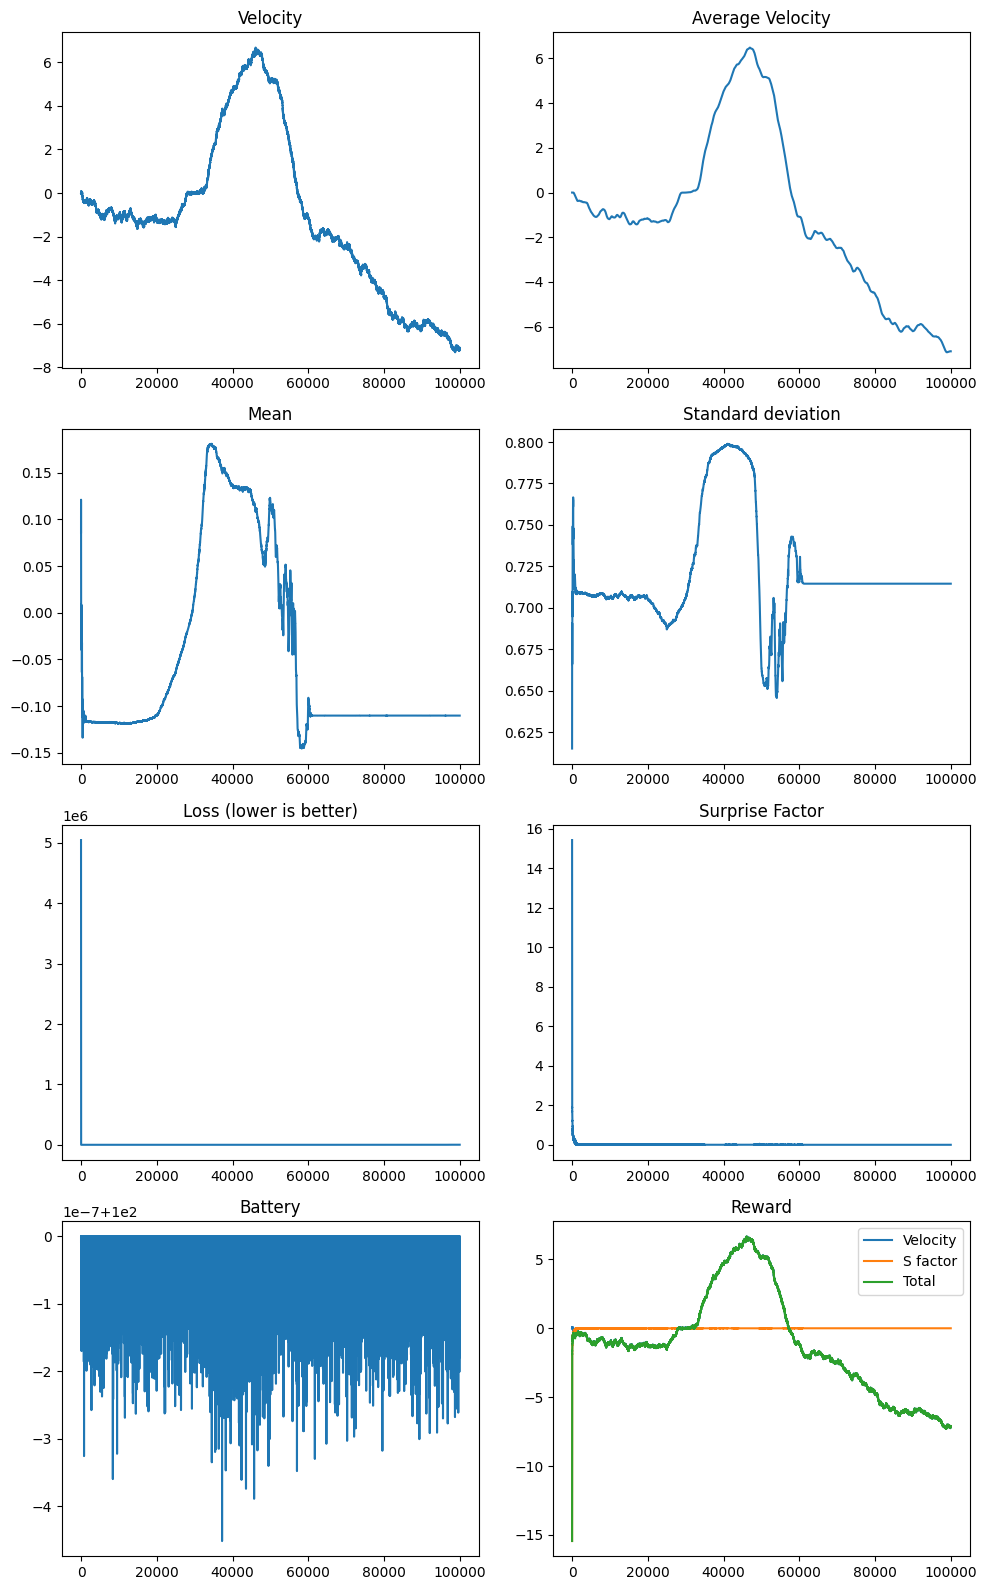

In [536]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 2, figsize=(10, 16))

axes = axes.flatten()

axes[0].plot(velocity_hist)
axes[0].set_title('Velocity')

axes[1].plot(avg_velocity_hist)
axes[1].set_title('Average Velocity')

axes[2].plot(model.mean_history)
axes[2].set_title('Mean')

axes[3].plot(model.std_history)
axes[3].set_title('Standard deviation')

axes[4].plot(loss_history)
axes[4].set_title('Loss (lower is better)')

axes[5].plot(surprise_factor_history)
axes[5].set_title('Surprise Factor')

axes[6].plot(battery_hist)
axes[6].set_title('Battery')

axes[7].plot(v_reward_history, label="Velocity")
axes[7].plot(s_reward_history, label="S factor")
axes[7].plot(total_reward_history, label="Total")
axes[7].set_title('Reward')
axes[7].legend()

plt.tight_layout()

plt.show()